In [ ]:
!pip install gensim
!pip install transformers torch
!pip install sentence-transformers

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
import numpy as np
from transformers import BertTokenizer, BertModel
import torch
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping
from sentence_transformers import SentenceTransformer
from xgboost import plot_importance
import time
import shap
from xgboost import plot_tree
from sklearn.model_selection import GridSearchCV
%matplotlib inline
shap.initjs()

C:\Users\Naresh Kumar S\.anaconda\.anaconda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [ ]:
df=pd.read_csv('ethereum_news_cleaned.csv')

In [ ]:
df=df.drop('Unnamed: 0',axis=1)

In [ ]:
df=df.drop('Title',axis=1)

In [ ]:
df.columns


Index(['Unnamed: 0.1', 'Date', 'Source', 'Tokens', 'Open Price (USD)',
       'High Price (USD)', 'Low Price (USD)', 'Close Price (USD)', 'Volume',
       'VADER Sentiment', 'Price Change (%)', 'Cleaned Tokens',
       'General BERT Sentiment Score', 'General BERT Confidence Score',
       'TextBlob Sentiment', 'Absolute Price Change (%)',
       'VADER Sentiment Norm', 'General BERT Sentiment Norm',
       'TextBlob Sentiment Norm', 'Average Sentiment',
       'Price Change (%) Lagged', 'Volume Norm', 'Sentiment and Volume',
       'Month', 'Daily Range (USD)', 'Returns', 'Rolling Volatility'],
      dtype='object')

#Feature Selection

In [ ]:
df=df.drop(['Volume','General BERT Sentiment Score','General BERT Confidence Score', 'TextBlob Sentiment','VADER Sentiment Norm', 'General BERT Sentiment Norm', 'TextBlob Sentiment Norm','Month'],axis=1)

In [ ]:
df=df.drop(['Cleaned Tokens'], axis=1)

In [ ]:
min_max_scaler = MinMaxScaler()
cols=['Price Change (%)', 'Absolute Price Change (%)', 'Price Change (%) Lagged', 'Daily Range (USD)','Rolling Volatility']
df[cols] = min_max_scaler.fit_transform(df[cols])

In [ ]:
col=['Open Price (USD)',	'High Price (USD)'	,'Low Price (USD)',	'Close Price (USD)']
df[col] = min_max_scaler.fit_transform(df[col])

In [ ]:
df=df.drop(['VADER Sentiment','Source'],axis=1)

###TF-IDF

In [ ]:
tfidf = TfidfVectorizer(max_features=5000)
tfidf_embeddings = tfidf.fit_transform(df['Tokens']).toarray()

###Word2Vec

In [ ]:
sentences = df['Tokens'].tolist()
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
w2v_embeddings = []
for tokens in sentences:
    vectors = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
    if vectors:
        w2v_embeddings.append(np.mean(vectors, axis=0))
    else:
        w2v_embeddings.append(np.zeros(100))

w2v_embeddings = np.array(w2v_embeddings)

###BERT

In [ ]:
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
model = BertModel.from_pretrained('yiyanghkust/finbert-tone')

bert_embeddings = []
for headline in df['Tokens']:
    inputs = tokenizer(' '.join(headline), return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)


    embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    bert_embeddings.append(embedding)

bert_embeddings = np.array(bert_embeddings)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


###Sentence BERT

In [ ]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
sbert_embeddings = model.encode(df['Tokens'].apply(lambda x: ' '.join(x)))
sbert_embeddings = np.array(sbert_embeddings)

In [ ]:
df['TFIDF_Embeddings'] = list(tfidf_embeddings)
df['Word2Vec_Embeddings'] = list(w2v_embeddings)
df['BERT_Embeddings'] = list(bert_embeddings)
df['SBERT_Embeddings'] = list(sbert_embeddings)


In [ ]:
print("Current DataFrame columns:")
print(df.columns.tolist())
df.columns = df.columns.str.strip().str.replace(' ', '_').str.replace('\t', '')
print("Cleaned column names:")
print(df.columns.tolist())

Current DataFrame columns:
['Unnamed: 0.1', 'Date', 'Tokens', 'Open Price (USD)', 'High Price (USD)', 'Low Price (USD)', 'Close Price (USD)', 'Price Change (%)', 'Absolute Price Change (%)', 'Average Sentiment', 'Price Change (%) Lagged', 'Volume Norm', 'Sentiment and Volume', 'Daily Range (USD)', 'Returns', 'Rolling Volatility', 'TFIDF_Embeddings', 'Word2Vec_Embeddings', 'BERT_Embeddings', 'SBERT_Embeddings']
Cleaned column names:
['Unnamed:_0.1', 'Date', 'Tokens', 'Open_Price_(USD)', 'High_Price_(USD)', 'Low_Price_(USD)', 'Close_Price_(USD)', 'Price_Change_(%)', 'Absolute_Price_Change_(%)', 'Average_Sentiment', 'Price_Change_(%)_Lagged', 'Volume_Norm', 'Sentiment_and_Volume', 'Daily_Range_(USD)', 'Returns', 'Rolling_Volatility', 'TFIDF_Embeddings', 'Word2Vec_Embeddings', 'BERT_Embeddings', 'SBERT_Embeddings']


#Model Training

In [ ]:
feature_columns = ['Open_Price_(USD)', 'High_Price_(USD)', 'Low_Price_(USD)', 'Close_Price_(USD)', 'Average_Sentiment', 'Volume_Norm', 'Sentiment_and_Volume', 'TFIDF_Embeddings']
target_column = 'Price_Change_(%)'

##Random Forest Regressor

In [ ]:
base_features = [
    'Open_Price_(USD)', 'High_Price_(USD)', 'Low_Price_(USD)', 'Average_Sentiment',
    'Volume_Norm', 'Sentiment_and_Volume'
]
embeddings = ['TFIDF_Embeddings', 'Word2Vec_Embeddings', 'BERT_Embeddings', 'SBERT_Embeddings']
target_column = 'Price_Change_(%)'

results = {}
for embedding in embeddings:
    print(f"Training model using {embedding}...")
    start_time = time.time()
    X = df[base_features + [embedding]]
    y = df[target_column]
    if isinstance(X[embedding].iloc[0], (list, np.ndarray)):
        X_embeddings = np.stack(X[embedding].values)
        embedding_columns = [f"{embedding}_{i}" for i in range(X_embeddings.shape[1])]
        X = X.drop(columns=[embedding])
        X = pd.DataFrame(np.concatenate((X.values, X_embeddings), axis=1), columns=X.columns.tolist() + embedding_columns)

    # Dataset Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Random Forest Regressor
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # time computation
    end_time = time.time()
    elapsed_time = end_time - start_time

    results[embedding] = {
        'Mean Squared Error': mse,
        'R² Score': r2,
        'Root Mean Squared Error': rmse,
        'Time Taken (seconds)': elapsed_time
    }
    print(f"{embedding} - Mean Squared Error: {mse}, R² Score: {r2}, Root Mean Squared Error: {rmse}, Time Taken: {elapsed_time:.2f} seconds")

results_df = pd.DataFrame(results).T
print("\nPerformance of different embeddings:")
print(results_df)

Training model using TFIDF_Embeddings...
TFIDF_Embeddings - Mean Squared Error: 0.00039466905277465856, R² Score: 0.977450763952311, Root Mean Squared Error: 0.019866279288650368, Time Taken: 2.81 seconds
Training model using Word2Vec_Embeddings...
Word2Vec_Embeddings - Mean Squared Error: 0.0010713428170711441, R² Score: 0.9387893175299797, Root Mean Squared Error: 0.03273137358974023, Time Taken: 6.70 seconds
Training model using BERT_Embeddings...
BERT_Embeddings - Mean Squared Error: 0.0020695996966780938, R² Score: 0.8817543667117334, Root Mean Squared Error: 0.04549285324837401, Time Taken: 53.11 seconds
Training model using SBERT_Embeddings...
SBERT_Embeddings - Mean Squared Error: 0.0018814939725568208, R² Score: 0.8925017013337714, Root Mean Squared Error: 0.04337619130994353, Time Taken: 26.45 seconds

Performance of different embeddings:
                     Mean Squared Error  R² Score  Root Mean Squared Error  \
TFIDF_Embeddings               0.000395  0.977451            

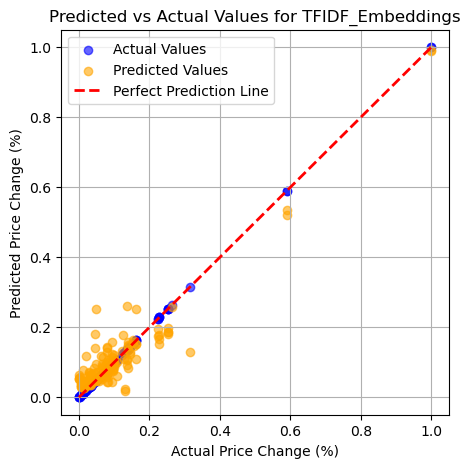

In [ ]:
last_embedding = embeddings[0]
y_test_last = y_test
y_pred_last = model.predict(X_test)


plt.figure(figsize=(5, 5))
plt.scatter(y_test_last, y_test_last, alpha=0.6, color='blue', label='Actual Values')
plt.scatter(y_test_last, y_pred_last, alpha=0.6, color='orange', label='Predicted Values')
plt.plot([y_test_last.min(), y_test_last.max()],
         [y_test_last.min(), y_test_last.max()],
         'r--', lw=2, label='Perfect Prediction Line')
plt.title(f'Predicted vs Actual Values for {last_embedding}')
plt.xlabel('Actual Price Change (%)')
plt.ylabel('Predicted Price Change (%)')
plt.legend()
plt.grid()
plt.show()

#XG Boost Regressor

In [ ]:
results = {}

# Hyperparameters for Grid Search
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.3, 0.5, 0.8]
}

for embedding in embeddings:
    print(f"Training XGBoost model using {embedding}...")
    X = df[base_features + [embedding]]
    y = df[target_column]
    if isinstance(X[embedding].iloc[0], (list, np.ndarray)):
        X_embeddings = np.stack(X[embedding].values)
        X = X.drop(columns=[embedding])
        X = pd.DataFrame(np.concatenate((X.values, X_embeddings), axis=1))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # XGBoost Regressor
    modelXG = XGBRegressor(random_state=42)
    grid_search = GridSearchCV(
        estimator=modelXG,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=3,
        verbose=1
    )
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    end_time = time.time()
    elapsed_time = end_time - start_time
    results[embedding] = {
        'Best Parameters': grid_search.best_params_,
        'Mean Squared Error': mse,
        'R² Score': r2,
        'Root Mean Squared Error': rmse,
        'Time Taken (seconds)': elapsed_time
    }
    print(f"{embedding} - Best Parameters: {grid_search.best_params_}, Mean Squared Error: {mse}, R² Score: {r2}, Root Mean Squared Error: {rmse}, Time Taken: {elapsed_time:.2f} seconds")

results_df = pd.DataFrame(results).T
print("\nPerformance of different embeddings:")
print(results_df)

Training XGBoost model using TFIDF_Embeddings...
Fitting 3 folds for each of 162 candidates, totalling 486 fits
TFIDF_Embeddings - Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}, Mean Squared Error: 0.0003130340610998918, R² Score: 0.9821149419112464, Root Mean Squared Error: 0.017692768610364288, Time Taken: 1052.43 seconds
Training XGBoost model using Word2Vec_Embeddings...
Fitting 3 folds for each of 162 candidates, totalling 486 fits
Word2Vec_Embeddings - Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}, Mean Squared Error: 0.0007839929138566972, R² Score: 0.9552069229903266, Root Mean Squared Error: 0.027999873461440807, Time Taken: 294.16 seconds
Training XGBoost model using BERT_Embeddings...
Fitting 3 folds for each of 162 candidates, totalling 486 fits
BERT_Embeddings - Best Parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.1, '

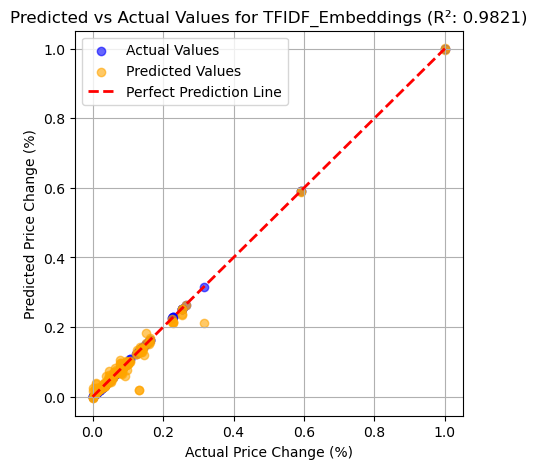

In [ ]:
best_embedding = results_df['R² Score'].idxmax()
best_r2_score = results_df.loc[best_embedding, 'R² Score']
X = df[base_features + [best_embedding]]
y = df[target_column]
if isinstance(X[best_embedding].iloc[0], (list, np.ndarray)):
    X_embeddings = np.stack(X[best_embedding].values)
    X = X.drop(columns=[best_embedding])
    X = pd.DataFrame(np.concatenate((X.values, X_embeddings), axis=1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
best_model = XGBRegressor(**results_df.loc[best_embedding, 'Best Parameters'])  # Use best params
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_test, alpha=0.6, color='blue', label='Actual Values')
plt.scatter(y_test, y_pred, alpha=0.6, color='orange', label='Predicted Values')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2, label='Perfect Prediction Line')
plt.title(f'Predicted vs Actual Values for {best_embedding} (R²: {best_r2_score:.4f})')
plt.xlabel('Actual Price Change (%)')
plt.ylabel('Predicted Price Change (%)')
plt.legend()
plt.grid()
plt.show()

#Explainable AI - XGB

In [ ]:
column_names = base_features + [f'Embedding_{i}' for i in range(X_embeddings.shape[1])]
X.columns = column_names
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the XGBoost model
best_model = XGBRegressor(**results_df.loc[best_embedding, 'Best Parameters'])
best_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

##PDP

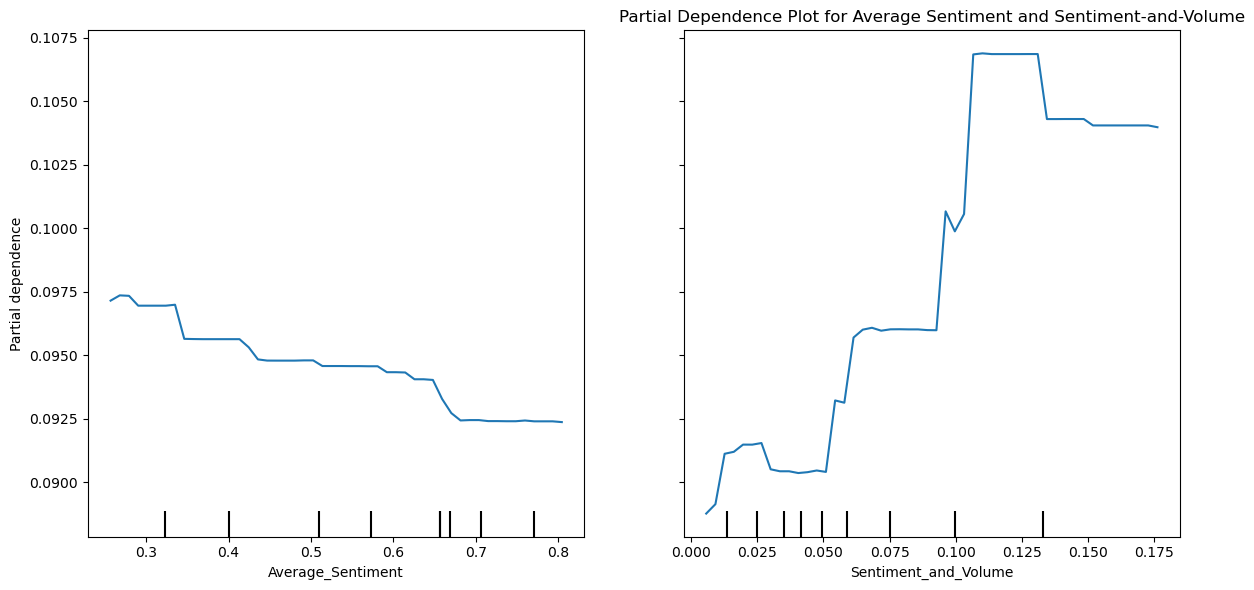

In [ ]:
numeric_features = list(range(X_train.shape[1]))
core_features = [numeric_features[column_names.index(f)] for f in ['Average_Sentiment', 'Sentiment_and_Volume'] if f in column_names]
features_to_analyze = core_features
fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(
    best_model, X_train, features=features_to_analyze,
    kind="average", grid_resolution=50, ax=ax
)
plt.title('Partial Dependence Plot for Average Sentiment and Sentiment-and-Volume')
plt.tight_layout()
plt.show()


##ICE

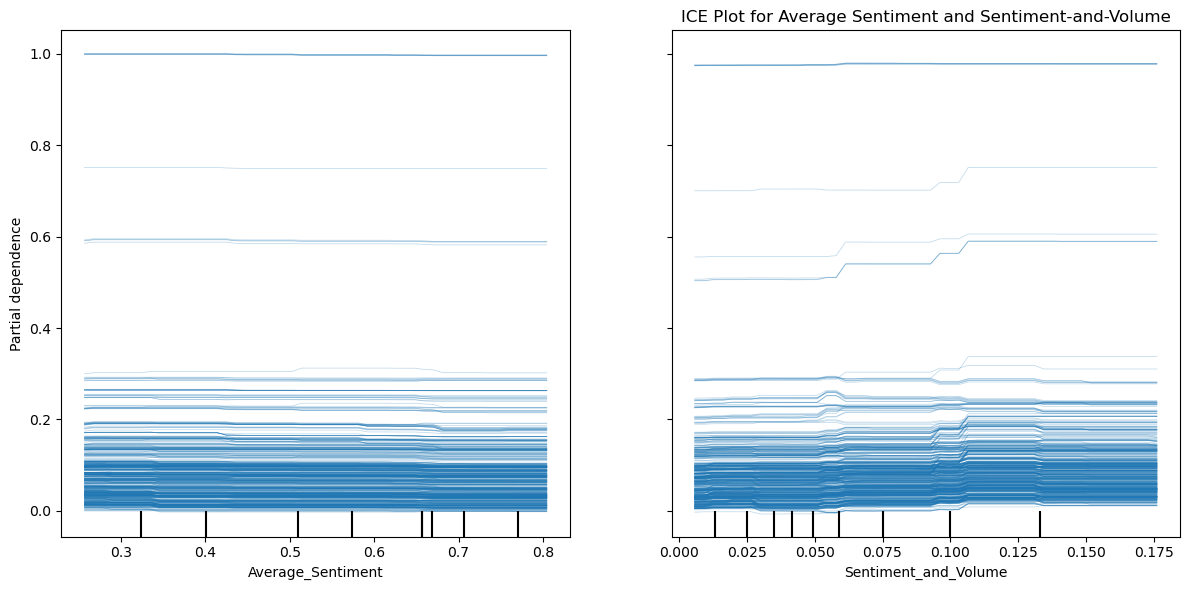

In [ ]:
numeric_features = list(range(X_train.shape[1]))
core_features = [numeric_features[column_names.index(f)] for f in ['Average_Sentiment', 'Sentiment_and_Volume'] if f in column_names]

features_to_analyze = core_features
fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(
    best_model, X_train, features=features_to_analyze,
    kind="individual", grid_resolution=50, ax=ax
)

plt.title('ICE Plot for Average Sentiment and Sentiment-and-Volume')
plt.tight_layout()
plt.show()

##SHAP Analysis

In [ ]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
sentiment_volume_idx = X_test.columns.get_loc('Sentiment_and_Volume')
sentiment_volume_shap = shap_values[:, sentiment_volume_idx]
high_sentiment_volume = X_test['Sentiment_and_Volume'] > X_test['Sentiment_and_Volume'].quantile(0.75)
high_sentiment_shap = sentiment_volume_shap[high_sentiment_volume]

positive_contributions = (high_sentiment_shap > 0).sum()
total_contributions = len(high_sentiment_shap)

print(f"Positive SHAP contributions: {positive_contributions} out of {total_contributions}")

Positive SHAP contributions: 39 out of 40


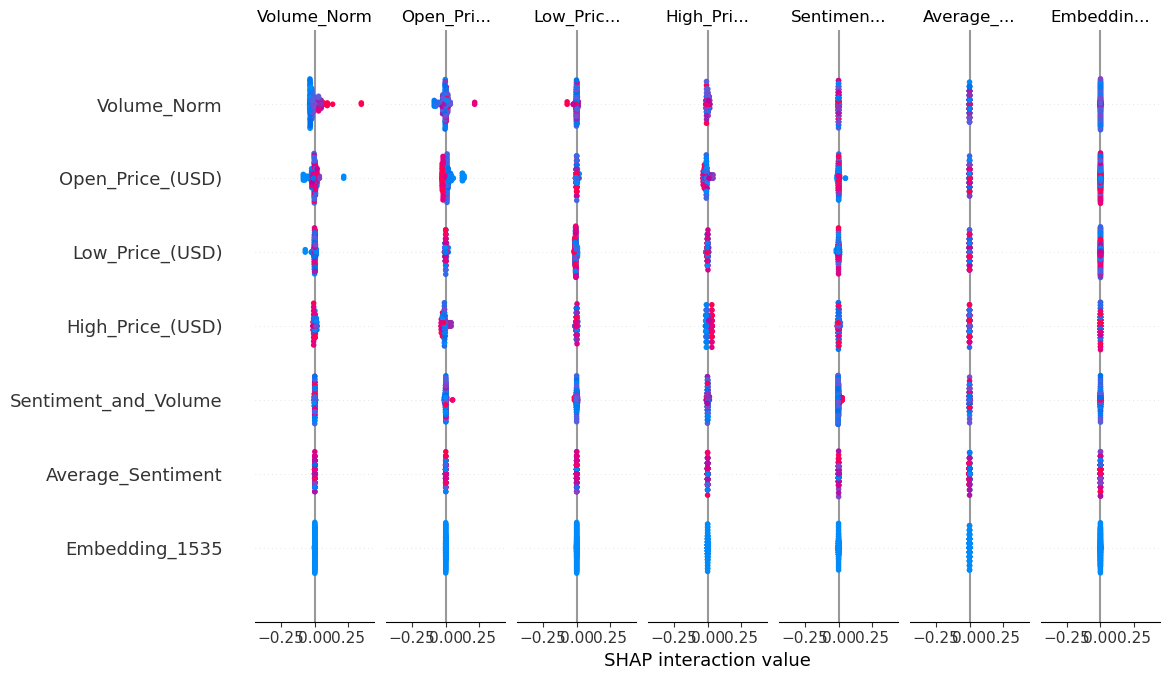

In [ ]:
explainer = shap.TreeExplainer(best_model)
shap_values_interaction = explainer.shap_interaction_values(X_test)
shap.summary_plot(shap_values_interaction, X_test, feature_names=X_test.columns)

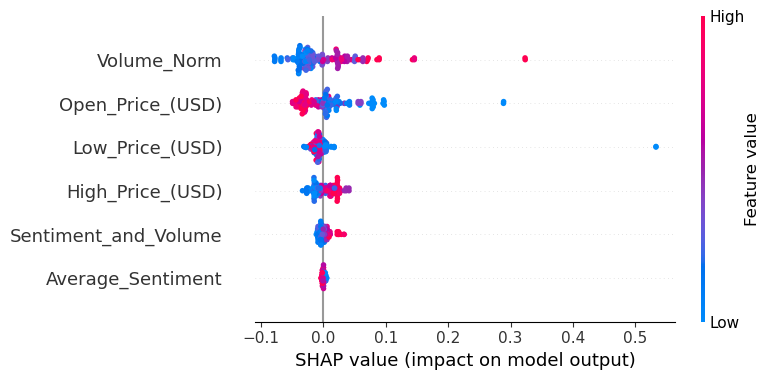

In [ ]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
X_test_subset = X_test.iloc[:, :6]
shap_values_subset = shap_values[:, :6]
shap.summary_plot(shap_values_subset, X_test_subset, feature_names=X_test_subset.columns)

##LSTM

In [ ]:
results = {}
for embedding in embeddings:
    print(f"Training LSTM model using {embedding}...")
    X = df[base_features + [embedding]]
    y = df[target_column]

    if isinstance(X[embedding].iloc[0], (list, np.ndarray)):
        X_embeddings = np.stack(X[embedding].values)
        X = X.drop(columns=[embedding])
        X = pd.DataFrame(np.concatenate((X.values, X_embeddings), axis=1))
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

    X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=10, batch_size=8, verbose=0)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    end_time = time.time()
    elapsed_time = end_time - start_time
    results[embedding] = {
        'Mean Squared Error': mse,
        'R² Score': r2,
        'Root Mean Squared Error': rmse,
        'Time Taken (seconds)': elapsed_time
    }
    print(f"{embedding} - Mean Squared Error: {mse}, R² Score: {r2}, Root Mean Squared Error: {rmse}, Time Taken: {elapsed_time:.2f} seconds")

results_df = pd.DataFrame(results).T
print("\nPerformance of different embeddings:")
print(results_df)

Training LSTM model using TFIDF_Embeddings...


C:\Users\Naresh Kumar S\.anaconda\.anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
TFIDF_Embeddings - Mean Squared Error: 0.008226938000708093, R² Score: 0.5299576553482921, Root Mean Squared Error: 0.0907024696505453, Time Taken: 1809.63 seconds
Training LSTM model using Word2Vec_Embeddings...


C:\Users\Naresh Kumar S\.anaconda\.anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Word2Vec_Embeddings - Mean Squared Error: 0.0072209972352933515, R² Score: 0.5874316214722111, Root Mean Squared Error: 0.08497645106318191, Time Taken: 1815.18 seconds
Training LSTM model using BERT_Embeddings...


C:\Users\Naresh Kumar S\.anaconda\.anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
BERT_Embeddings - Mean Squared Error: 0.017332381471105288, R² Score: 0.009722301982227344, Root Mean Squared Error: 0.13165250271493242, Time Taken: 1822.33 seconds
Training LSTM model using SBERT_Embeddings...


C:\Users\Naresh Kumar S\.anaconda\.anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
SBERT_Embeddings - Mean Squared Error: 0.0164123433489678, R² Score: 0.06228825982234221, Root Mean Squared Error: 0.1281106683651592, Time Taken: 1828.32 seconds

Performance of different embeddings:
                     Mean Squared Error  R² Score  Root Mean Squared Error  \
TFIDF_Embeddings               0.008227  0.529958                 0.090702   
Word2Vec_Embeddings            0.007221  0.587432                 0.084976   
BERT_Embeddings                0.017332  0.009722                 0.131653   
SBERT_Embeddings               0.016412  0.062288                 0.128111   

                     Time Taken (seconds)  
TFIDF_Embeddings              1809.632197  
Word2Vec_Embeddings           1815.184139  
BERT_Embeddings               1822.326937  
SBERT_Embeddings              1828.319779  


The best embedding based on R² Score is: Word2Vec_Embeddings
R² Score: 0.5874316214722111


C:\Users\Naresh Kumar S\.anaconda\.anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


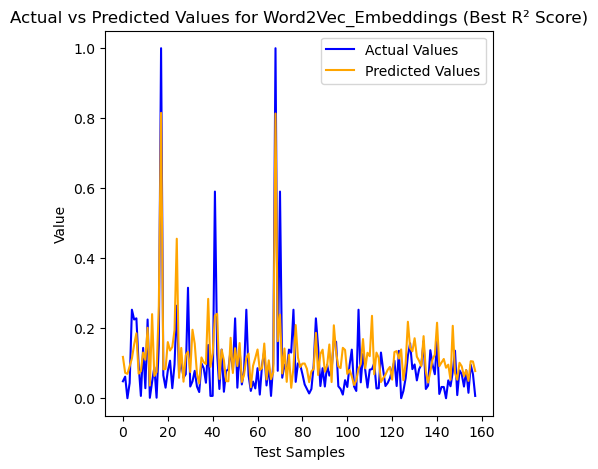

In [ ]:
best_embedding = max(results, key=lambda embedding: results[embedding]['R² Score'])
print(f"The best embedding based on R² Score is: {best_embedding}")
print(f"R² Score: {results[best_embedding]['R² Score']}")
X_best = df[base_features + [best_embedding]]
y_best = df[target_column]
if isinstance(X_best[best_embedding].iloc[0], (list, np.ndarray)):
    X_embeddings = np.stack(X_best[best_embedding].values)
    X_best = X_best.drop(columns=[best_embedding])
    X_best = pd.DataFrame(np.concatenate((X_best.values, X_embeddings), axis=1))

scaler = MinMaxScaler()
X_best_scaled = scaler.fit_transform(X_best)
X_best_reshaped = X_best_scaled.reshape((X_best_scaled.shape[0], 1, X_best_scaled.shape[1]))
X_train_best, X_test_best, y_train_best, y_test_best = train_test_split(X_best_reshaped, y_best, test_size=0.2, random_state=42)
model_best = Sequential()
model_best.add(LSTM(50, activation='relu', input_shape=(X_train_best.shape[1], X_train_best.shape[2])))
model_best.add(Dropout(0.2))
model_best.add(Dense(1))
model_best.compile(optimizer='adam', loss='mean_squared_error')
model_best.fit(X_train_best, y_train_best, epochs=10, batch_size=8, verbose=0)
y_pred_best = model_best.predict(X_test_best)

plt.figure(figsize=(5, 5))
plt.plot(y_test_best.values, label='Actual Values', color='blue')
plt.plot(y_pred_best, label='Predicted Values', color='orange')
plt.title(f'Actual vs Predicted Values for {best_embedding} (Best R² Score)')
plt.xlabel('Test Samples')
plt.ylabel('Value')
plt.legend()
plt.show()

###XG Boost for Hybrid Sentiments

In [ ]:
features = ['Sentiment_and_Volume', 'TFIDF_Embeddings']
target = 'Price_Change_(%)'
X = df[features]
y = df[target]
if isinstance(X['TFIDF_Embeddings'].iloc[0], str):
    X['TFIDF_Embeddings'] = X['TFIDF_Embeddings'].apply(lambda x: np.array([float(v) for v in x.split(',')]))

X = np.hstack((X['Sentiment_and_Volume'].values.reshape(-1, 1), np.vstack(X['TFIDF_Embeddings'].values)))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor(n_estimators=150, learning_rate=0.1, max_depth=5, random_state=42)

start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time
start_time = time.time()
y_pred = model.predict(X_test)
end_time = time.time()
prediction_time = end_time - start_time

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Training Time: {training_time:.2f} seconds")
print(f"Prediction Time: {prediction_time:.2f} seconds")
print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"R² Score: {r2}")

Training Time: 0.60 seconds
Prediction Time: 0.01 seconds
RMSE: 0.09582315663997985
MSE: 0.009182077348450115
R² Score: 0.4753862050173038


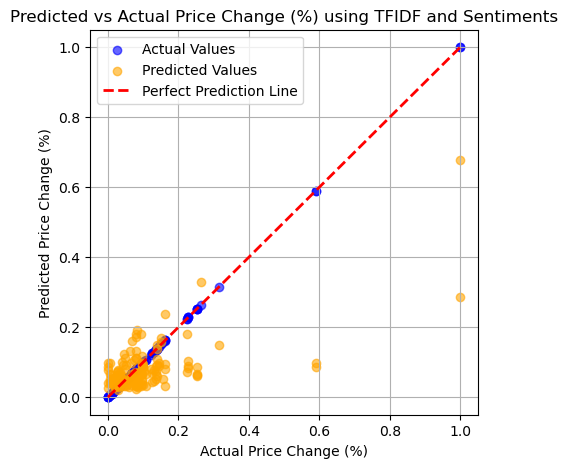

In [ ]:
last_embedding = "TFIDF"
y_test_last = y_test
y_pred_last = model.predict(X_test)

plt.figure(figsize=(5, 5))
plt.scatter(y_test_last, y_test_last, alpha=0.6, color='blue', label='Actual Values')
plt.scatter(y_test_last, y_pred_last, alpha=0.6, color='orange', label='Predicted Values')
plt.plot([y_test_last.min(), y_test_last.max()],
         [y_test_last.min(), y_test_last.max()],
         'r--', lw=2, label='Perfect Prediction Line')
plt.title(f'Predicted vs Actual Price Change (%) using {last_embedding} and Sentiments')
plt.xlabel('Actual Price Change (%)')
plt.ylabel('Predicted Price Change (%)')
plt.legend()
plt.grid()
plt.show()